# Detecção de Raças de Cachorros utilizando Redes Neurais

## Importações

### Importando biblioteca

In [67]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from sys import platform
import os 
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Image manipulation
import PIL.Image
from IPython.display import display

# Open a Zip File
from zipfile import ZipFile
from io import BytesIO


### Importando Dataset

In [68]:
if platform == "linux" or platform == "linux2":
    folder_path = os.getcwd() + "/" + "low-resolution"
elif platform == "win32":
   folder_path = os.getcwd() + "\\" + "low-resolution"


list_images = []

for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            
            file_path = os.path.join(subfolder_path, file)
            image_about = {}
            breed = subfolder.split("-")[-1]
            image_about["breed"] = breed
            image_about["filename"] = file
            image_about["path_file"] = file_path
            list_images.append(image_about)

df_images = pd.DataFrame.from_records(list_images)

In [69]:
df_images

,breed,filename,path_file
0,Shiba_Dog,n100001.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
1,Shiba_Dog,n100002.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
2,Shiba_Dog,n100003.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
3,Shiba_Dog,n100004.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
4,Shiba_Dog,n100005.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
...,...,...,...
7474,kelpie,n116125.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
7475,kelpie,n116126.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
7476,kelpie,n116127.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
7477,kelpie,n116128.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...


## Análise Exploratória de Dados

In [70]:
# counting images number of each breed of dog

# 130 breeds

distribuition_images = df_images.groupby(['breed'])['breed'].count()
#df2 = df2.reset_index()
#df2.columns = ['breed', 'count']
df2 = df_images.groupby('breed').size().reset_index(name='count')

df2

,breed,count
0,Brabancon_griffo,209
1,French_bulldog,1121
2,Pomeranian,1936
3,Shiba_Dog,1043
4,Siberian_husky,1160
5,West_Highland_white_terrier,209
6,dhole,209
7,kelpie,61
8,malamute,1324
9,redbone,207


In [71]:
#### Distribuição de raças

Text(0.5, 1.0, 'Distribuição de raças de cachorro')

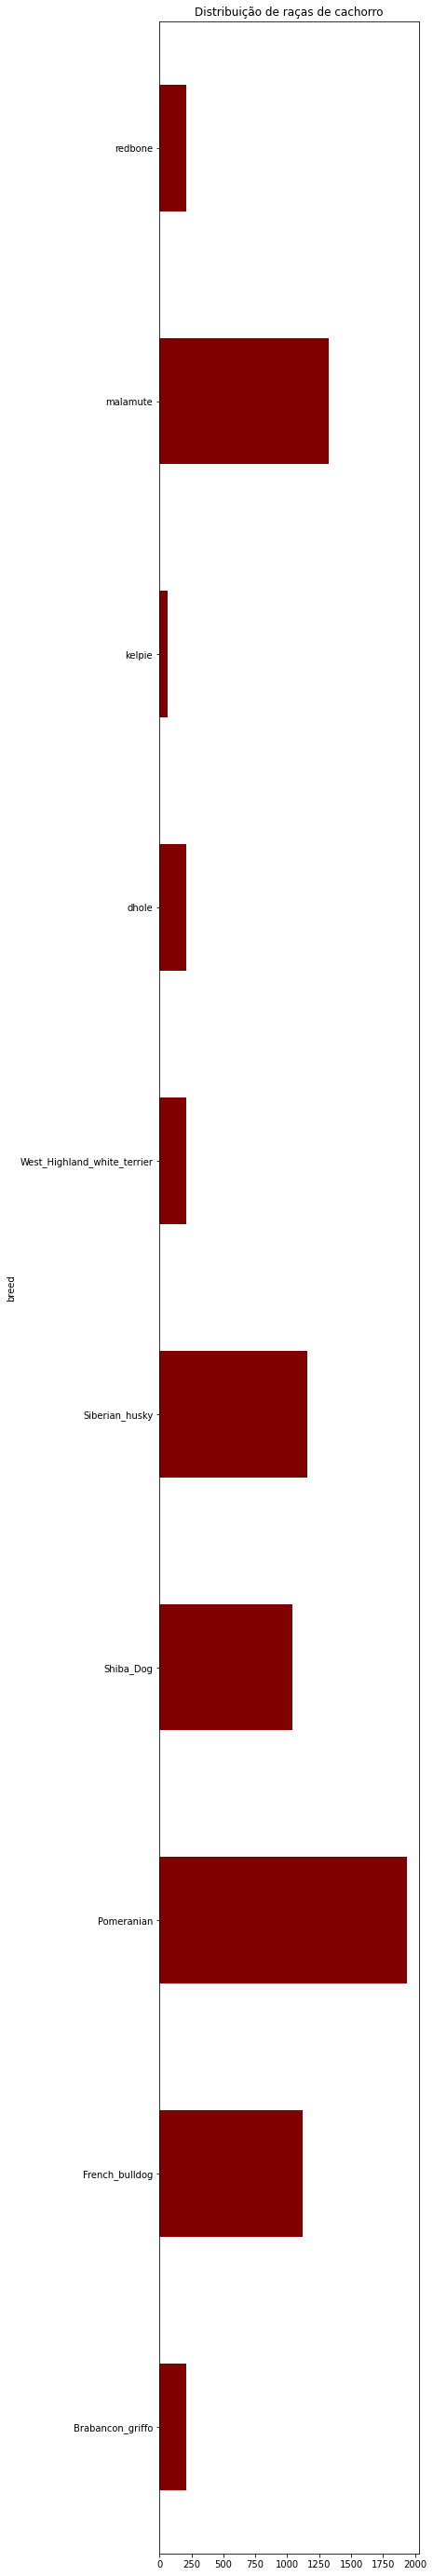

In [72]:
ax = distribuition_images.plot(x="Breed", y="Count", kind="barh",figsize=(5, 50))
distribuition_images.plot(x="breed", y="count", kind="barh", ax=ax, color="maroon")
ax.set_title('Distribuição de raças de cachorro')


### Visualizando imagens

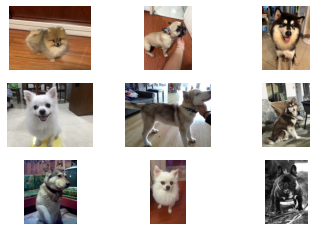

In [73]:
df = df_images.sample(n=9)
count = 0

for index, row in df.iterrows():
    image = Image.open(row["path_file"])

    # Exibir a imagem
    plt.subplot(3, 3, count + 1)
    plt.imshow(image)
    plt.axis('off')
    count += 1


In [74]:
df

,breed,filename,path_file
5064,Pomeranian,n105088.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
1338,French_bulldog,n101341.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
3635,malamute,n103650.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
5199,Pomeranian,n105223.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
3117,Siberian_husky,n103128.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
4069,malamute,n104084.jpeg,C:\Users\amand\Downloads\redes_neurais\low-res...
2255,Siberian_husky,n102260.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
5305,Pomeranian,n105329.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...
1184,French_bulldog,n101187.jpg,C:\Users\amand\Downloads\redes_neurais\low-res...


### Pré-processamento de imagens

#### Funções auxiliares para armazenar array de imagens em lotes

In [75]:
if platform == "linux" or platform == "linux2":
    os_path = "/" 
elif platform == "win32":
   os_path = "\\"

folder_path = os.getcwd() + os_path + "low-resolution"
slot_size = 70

#Retorna uma tupla com os path de cada imagem e o target randomizados
def load_path_of_dataset():
    arquivos = os.listdir(folder_path)
    subpastas = [subpasta for subpasta in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subpasta))]
    imagens_path = []
    labels = []
    for subpasta in subpastas:
        subpasta_path = os.path.join(folder_path, subpasta)
        imagens = os.listdir(subpasta_path)
        imagens_path.extend([subpasta + os_path + s for s in imagens])
        label = subpasta.split("-")[2]
        labels.extend([label for s in imagens])
    # minha_lista = list(zip(imagens_path, labels))
    # random.shuffle(minha_lista)
    return imagens_path, labels

#função responsavel em realizar a divisão em slots
#recebe como parametro a tupla da função load_path_of_dataset, e o numero da interação para carregar o dataframe
#retorna uma tupla menor, e o numero máximo de interações posiveis até o fim do dataset
def slot_loading(interacao, imagens_amostradas, imagens_labels):
    if interacao <= 0:
        raise ValueError('O valor da interação, deve ser maior que zero ! ')
    elif interacao > (interacao * len(imagens_amostradas)):
        raise ValueError('O valor da interação, é muito grande !')
    
    start_index = (interacao - 1) * slot_size
    end_index = interacao * slot_size
    if end_index > len(imagens_amostradas):
        return imagens_amostradas[start_index:], imagens_labels[start_index:]
    
    return imagens_amostradas[start_index:end_index], tf.convert_to_tensor(imagens_labels[start_index:end_index]), len(imagens_amostradas) // slot_size

#Recebe como parametro uma tupla
#retorna um dataset já pré-processado e formatados
def get_images(imagens_amostradas):
    img_size_height = 300
    img_size_width = 400
    images = []
    for imagem_nome in imagens_amostradas:
        try:
            imagem_path = os.path.join(folder_path, imagem_nome)
            imagem = Image.open(imagem_path)
            imagem = imagem.resize((img_size_width, img_size_height))  # Redimensiona para um tamanho comum
            imagem_array = np.array(imagem) / 255.0  # Normaliza dividindo por 255
            images.append(imagem_array)
        except Exception as error:
            print("ocorreu um erro com imagem_path: ", imagem_path, " imagem_nome " + imagem_nome," imagem_nome[0] " + imagem_nome[0], " imagens_amostradas: " , imagens_amostradas)
    images = tf.stack(images)
    return images


## Separação do Conjunto de teste e treino

In [76]:
# Sua tupla
X, y = load_path_of_dataset()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = y.tolist()
# Codifique os rótulos como vetores one-hot
y = tf.one_hot(y, depth=133)
# Converta o tensor para um array numpy
y = y.numpy()
# Separando 70% para treino e 30% para teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

# Exibindo as dimensões dos conjuntos de treino e teste
print("Dimensões do conjunto de treino:", len(X_treino), len(y_treino))
print("Dimensões do conjunto de teste:", len(X_teste), len(y_teste))

Dimensões do conjunto de treino: 5235 5235
Dimensões do conjunto de teste: 2244 2244


In [77]:
y_treino

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Criação do modelo

In [78]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
# Model Architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(300,400,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133,activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 300, 400, 16)      208       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 150, 200, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 150, 200, 32)      2080      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 75, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 75, 100, 64)       8256      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 37, 50, 64)      

### Treinamento em batch 

In [ ]:
# Treinar o modelo
x_new, y_new, i = slot_loading(1, X_treino, y_treino)
x_new_tensor = get_images(x_new)

model.fit(x_new_tensor, y_new)
for o in range(1, i):
    print( o," of " ,i)
    x_new, y_new = None, None
    x_new, y_new, i = slot_loading(o, X_treino, y_treino)
    x_new = get_images(x_new)
    model.fit(x_new , y_new)

1/3 [=========>....................] - ETA: 10s - loss: 0.6969 - accuracy: 0.0625

### Avaliação do modelo

In [ ]:
x_new, y_new, i = slot_loading(1, X_teste, y_teste)
x_new_tensor = get_images(x_new)
test_loss, test_accuracy = 0, 0
num_batches = 0

test_loss, test_accuracy = model.evaluate(X_teste, y_teste)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))
for o in range(1, i):
    print( o," of " ,i)
    x_new, y_new = None, None
    x_new, y_new, i = slot_loading(o, X_teste, y_teste)
    x_new = get_images(x_new)
    batch_loss, batch_accuracy  = model.evaluate(X_teste, y_teste)
    test_loss += batch_loss
    test_accuracy += batch_accuracy
    num_batches += 1
    print('Test loss: {}'.format(test_loss))
    print('Test accuracy: {}'.format(test_accuracy))

test_loss /= num_batches
test_accuracy /= num_batches

print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))